In [1]:
import quandl
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from matplotlib import cm, pyplot as plt
from hmmlearn.hmm import GaussianHMM
import scipy
import datetime
import json
import seaborn as sns
import joblib

In [25]:
start_date_string = '2014-04-01'
asset = 'BITFINEX/BTCUSD'
column_price = 'Last'
column_high = 'High'
column_low = 'Low'
column_volume = 'Volume'

quandl.ApiConfig.api_key = 'ja43bhBH89igZ11TdxtN'
dataset = quandl.get(asset, collapse = 'daily',
                     trim_start = start_date_string)
dataset = dataset.shift(1)

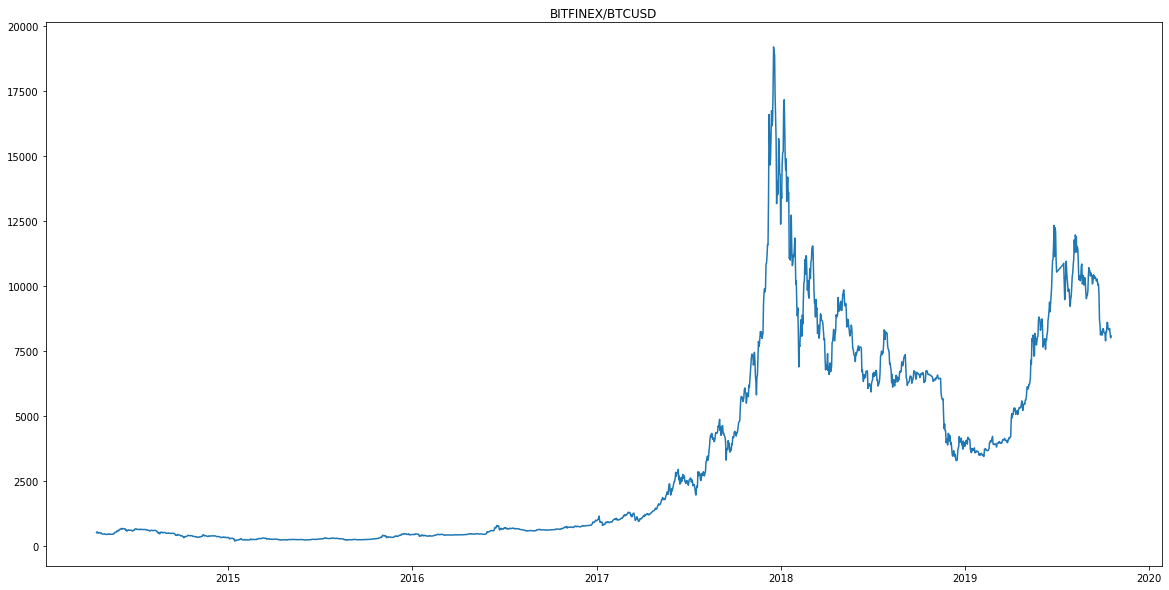

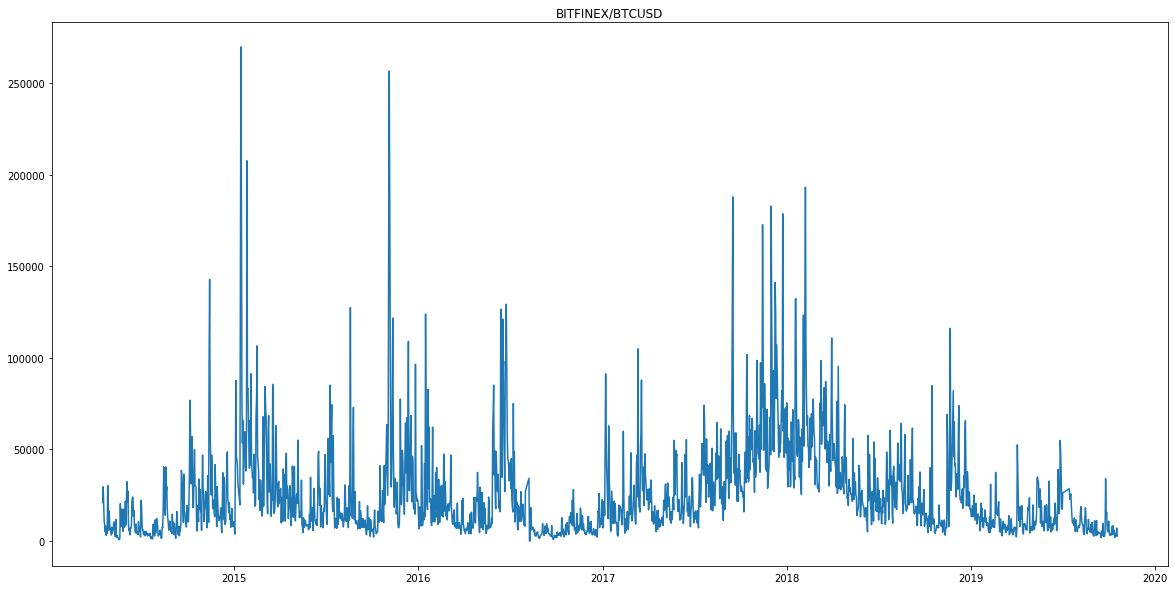

In [19]:
plt.figure(figsize=(20,10))
plt.plot(dataset[column_price])
plt.title(asset)
plt.show()
    
plt.figure(figsize=(20,10))
plt.plot(dataset[column_volume])
plt.title(asset)
plt.show()

In [4]:
import warnings
warnings.filterwarnings("ignore")

# Brute force modelling
def get_best_hmm_model(X, max_states, max_iter = 10000):
    best_score = -(10 ** 10)
    best_state = 0
    
    for state in range(1, max_states + 1):
        hmm_model = GaussianHMM(n_components = state, random_state = 100,
                                covariance_type = "diag", n_iter = max_iter).fit(X)
        if hmm_model.score(X) > best_score:
            best_score = hmm_model.score(X)
            best_state = state
    
    best_model = GaussianHMM(n_components = best_state, random_state = 100,
                                covariance_type = "diag", n_iter = max_iter).fit(X)
    return best_model

# Normalized st. deviation
def std_normalized(vals):
    return np.std(vals) / np.mean(vals)

# Ratio of diff between last price and mean value to last price
def ma_ratio(vals):
    return (vals[-1] - np.mean(vals)) / vals[-1]

# z-score for volumes and price
def values_deviation(vals):
    return (vals[-1] - np.mean(vals)) / np.std(vals)

# General plots of hidden states
def plot_hidden_states(hmm_model, data, X, column_price):
    plt.figure(figsize=(15, 15))
    fig, axs = plt.subplots(hmm_model.n_components, 3, figsize = (15, 15))
    colours = cm.prism(np.linspace(0, 1, hmm_model.n_components))
    hidden_states = model.predict(X)
    
    for i, (ax, colour) in enumerate(zip(axs, colours)):
        mask = hidden_states == i
        ax[0].plot(data.index, data[column_price], c = 'grey')
        ax[0].plot(data.index[mask], data[column_price][mask], '.', c = colour)
        ax[0].set_title("{0}th hidden state".format(i))
        ax[0].grid(True)
        
        ax[1].hist(data["future_return"][mask], bins = 30)
        ax[1].set_xlim([-0.1, 0.1])
        ax[1].set_title("future return distrbution at {0}th hidden state".format(i))
        ax[1].grid(True)
        
        ax[2].plot(data["future_return"][mask].cumsum(), c = colour)
        ax[2].set_title("cummulative future return at {0}th hidden state".format(i))
        ax[2].grid(True)
        
    plt.tight_layout()

def mean_confidence_interval(vals, confidence):
    a = 1.0 * np.array(vals)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m - h, m, m + h

def compare_hidden_states(hmm_model, cols_features, conf_interval, iters = 1000):
    plt.figure(figsize=(15, 15))
    fig, axs = plt.subplots(len(cols_features), hmm_model.n_components, figsize = (15, 15))
    colours = cm.prism(np.linspace(0, 1, hmm_model.n_components))
    
    for i in range(0, model.n_components):
        mc_df = pd.DataFrame()
    
        # Samples generation
        for j in range(0, iters):
            row = np.transpose(hmm_model._generate_sample_from_state(i))
            mc_df = mc_df.append(pd.DataFrame(row).T)
        mc_df.columns = cols_features
    
        for k in range(0, len(mc_df.columns)):
            axs[k][i].hist(mc_df[cols_features[k]], color = colours[i])
            axs[k][i].set_title(cols_features[k] + " (state " + str(i) + "): " + str(np.round(mean_confidence_interval(mc_df[cols_features[k]], conf_interval), 3)))
            axs[k][i].grid(True)
            
    plt.tight_layout()

<Figure size 1440x720 with 0 Axes>

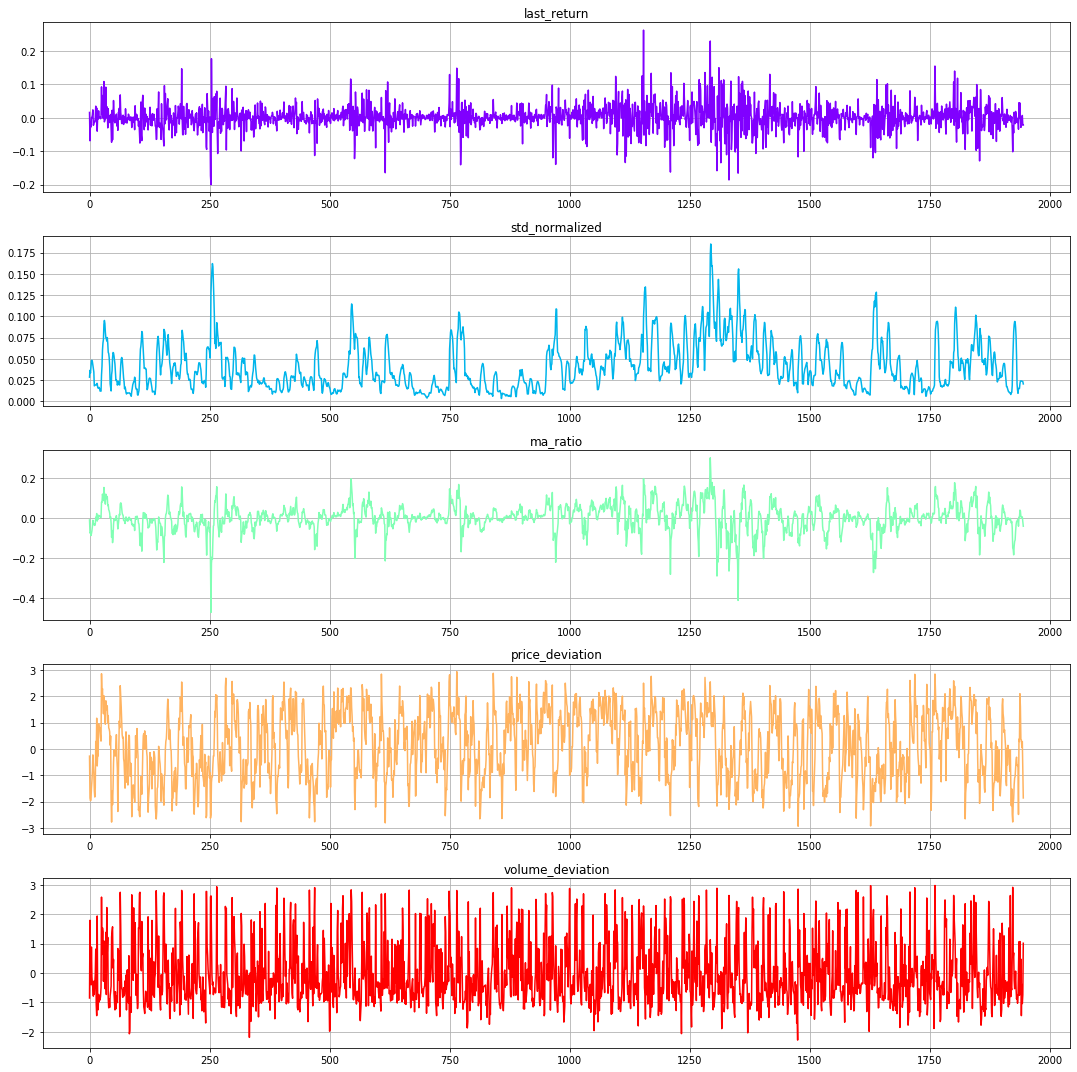

In [27]:
# Feature params
future_period = 1
std_period = 10
ma_period = 10
price_deviation_period = 10
volume_deviation_period = 10

# Create features
cols_features = ['last_return', 'std_normalized', 'ma_ratio', 'price_deviation', 'volume_deviation']
dataset['last_return'] = dataset[column_price].pct_change()
dataset['std_normalized'] = dataset[column_price].rolling(std_period).apply(std_normalized)
dataset['ma_ratio'] = dataset[column_price].rolling(ma_period).apply(ma_ratio)
dataset['price_deviation'] = dataset[column_price].rolling(price_deviation_period).apply(values_deviation)
dataset['volume_deviation'] = dataset[column_volume].rolling(volume_deviation_period).apply(values_deviation)

dataset["future_return"] = dataset[column_price].pct_change(future_period).shift(-future_period)

dataset = dataset.replace([np.inf, -np.inf], np.nan)
dataset = dataset.dropna()

# Split the data on sets
train_ind = int(np.where(dataset.index == '2018-01-01 00:00:00')[0])
train_set = dataset[cols_features].values[:train_ind]
test_set = dataset[cols_features].values[train_ind:]

# Plot features
plt.figure(figsize=(20,10))
fig, axs = plt.subplots(len(cols_features), 1, figsize = (15, 15))
colours = cm.rainbow(np.linspace(0, 1, len(cols_features)))
for i in range(0, len(cols_features)):
    axs[i].plot(dataset.reset_index()[cols_features[i]], color = colours[i])
    axs[i].set_title(cols_features[i])
    axs[i].grid(True)

plt.tight_layout()

In [42]:
model = get_best_hmm_model(X = train_set, max_states = 3, max_iter = 1000000)
print("Best model with {0} states ".format(str(model.n_components)))

Best model with 3 states 


<Figure size 1080x1080 with 0 Axes>

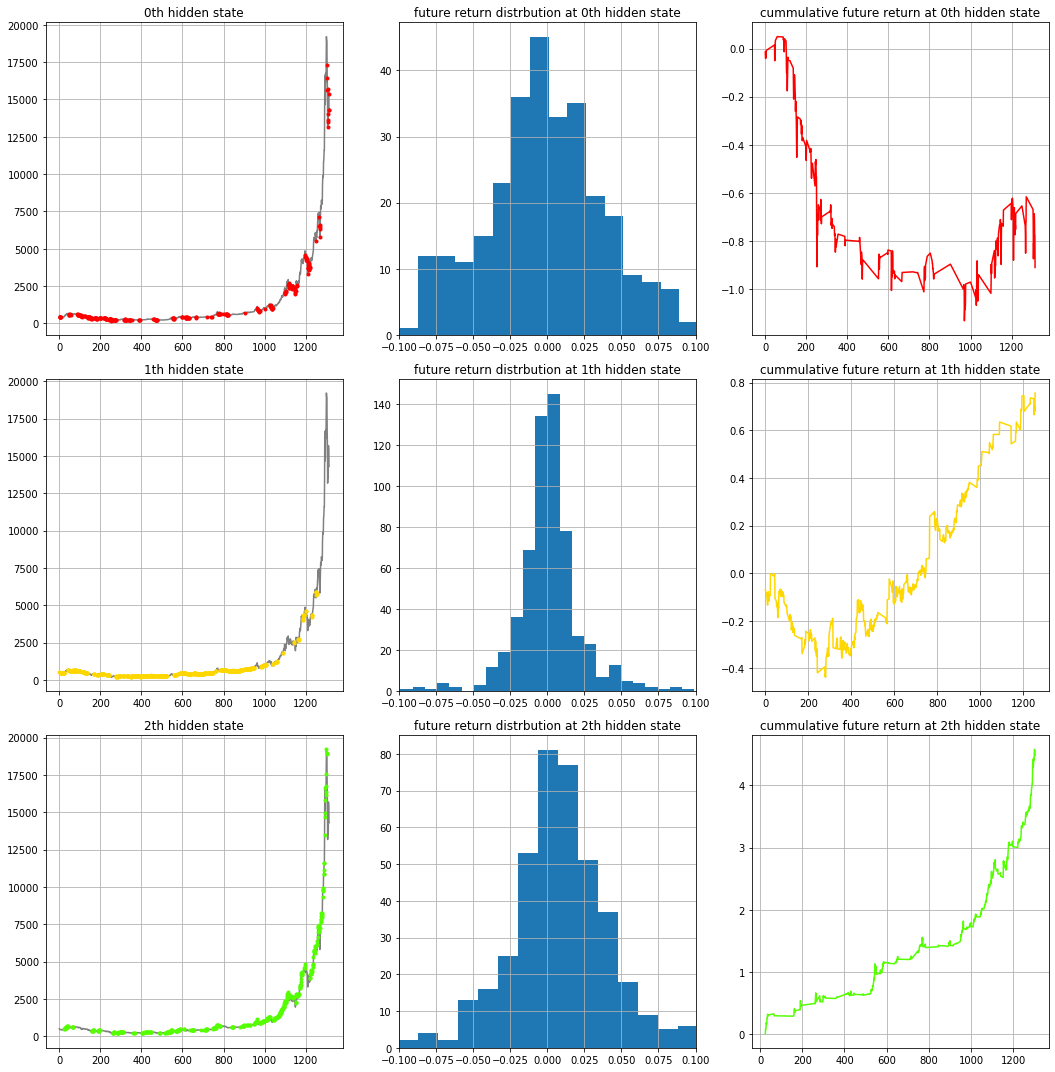

In [43]:
# General plots of hidden states
def plot_hidden_states(hmm_model, data, X, column_price):
    plt.figure(figsize=(15, 15))
    fig, axs = plt.subplots(hmm_model.n_components, 3, figsize = (15, 15))
    colours = cm.prism(np.linspace(0, 1, hmm_model.n_components))
    hidden_states = model.predict(X)
    
    for i, (ax, colour) in enumerate(zip(axs, colours)):
        mask = hidden_states == i

        ax[0].plot(data.index.values, data[column_price], c = 'grey')
        ax[0].plot(data.index[mask].values, data[column_price][mask], '.', c = colour)
        ax[0].set_title("{0}th hidden state".format(i))
        ax[0].grid(True)
        
        ax[1].hist(data["future_return"][mask], bins = 30)
        ax[1].set_xlim([-0.1, 0.1])
        ax[1].set_title("future return distrbution at {0}th hidden state".format(i))
        ax[1].grid(True)
        
        ax[2].plot(data["future_return"][mask].cumsum(), c = colour)
        ax[2].set_title("cummulative future return at {0}th hidden state".format(i))
        ax[2].grid(True)
        
    plt.tight_layout()


plot_hidden_states(model, dataset[:train_ind].reset_index(), train_set, column_price)

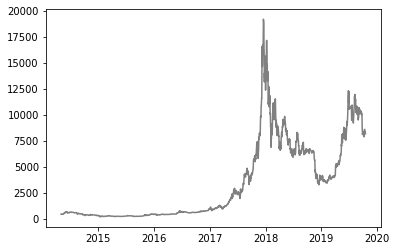

In [16]:
plt.plot(dataset.index, dataset[column_price], c = 'grey')

In [32]:
dataset

,High,Low,Mid,Last,Bid,Ask,Volume,last_return,std_normalized,ma_ratio,price_deviation,volume_deviation,future_return
Date,,,,,,,,,,,,,
2014-04-25,498.839600,480.160000,497.49000,497.980000,497.0000,497.9800,4316.108888,0.016223,0.028480,-0.007852,-0.273547,-0.849683,-0.068657
2014-04-26,504.960000,441.300000,464.87250,463.790000,463.7900,465.9550,30376.947882,-0.068657,0.036579,-0.073264,-1.866190,1.793776,-0.013347
2014-04-27,469.190000,449.800100,458.30000,457.600000,457.6000,459.0000,8578.837107,-0.013347,0.033327,-0.070212,-1.968552,-0.226169,-0.027535
2014-04-28,465.600000,440.000000,445.70500,445.000000,445.5000,445.9100,5959.686438,-0.027535,0.041027,-0.086357,-1.937563,-0.399661,0.000899
2014-04-29,450.000000,423.110000,445.45000,445.400000,445.4000,445.5000,16467.531309,0.000899,0.047720,-0.076996,-1.498142,0.884111,0.000314
2014-04-30,454.000000,434.000000,446.27505,445.540000,445.5501,447.0000,8521.438599,0.000314,0.048388,-0.062751,-1.220256,-0.126299,0.008596
2014-05-01,453.600000,432.000000,449.36500,449.370000,449.3600,449.3700,6877.398301,0.008596,0.046686,-0.042106,-0.865455,-0.365772,0.023878
2014-05-02,463.530000,446.990000,459.59500,460.100000,459.1000,460.0900,5339.533294,0.023878,0.042432,-0.009783,-0.228315,-0.521717,-0.022278
2014-05-03,461.669900,443.000000,449.65500,449.850000,449.4600,449.8500,3298.963199,-0.022278,0.039003,-0.023599,-0.591101,-0.786253,-0.019006
